In [0]:
from torchvision import models
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
import numpy as np
import cv2
dlab = models.segmentation.deeplabv3_resnet101(pretrained=1).eval()

2019-07-28 17:21:16 URL:https://cdn.pixabay.com/photo/2017/09/04/20/52/bald-eagle-2715461_1280.jpg [139202/139202] -> "eagle.png" [1]


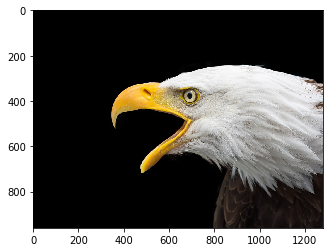

torch.Size([1, 21, 224, 224])


In [0]:
!wget -nv https://cdn.pixabay.com/photo/2017/09/04/20/52/bald-eagle-2715461_1280.jpg -O eagle.png
img = Image.open('./eagle.png')

trf = T.Compose([T.Resize(256),T.CenterCrop(224),T.ToTensor(),T.Normalize(mean = [0.485, 0.456, 0.406],std = [0.229, 0.224, 0.225])])
inp = trf(img).unsqueeze(0)
out = dlab(inp)['out']
print (out.shape)

In [0]:
om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
print (om.shape)

(224, 224)


In [0]:
import cv2
def decode_segmap(image, source, nc=21):
  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])
 
  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)

    
  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
     
  rgb = np.stack([r, g, b], axis=2)
  

  foreground = cv2.imread(source)
  foreground = cv2.cvtColor(foreground, cv2.COLOR_BGR2RGB)
  foreground = cv2.resize(foreground ,(r.shape[1], r.shape[0]))
  blurImage = cv2.GaussianBlur(foreground , (7,7),0)
  foreground = foreground.astype(float)
  blurredImage = blurImage.astype(float)
  th, alpha = cv2.threshold(np.array(rgb),0,255, cv2.THRESH_BINARY)
  alpha = cv2.GaussianBlur(alpha , (7,7),0)
  alpha = alpha.astype(float)/255
  foreground = cv2.multiply(alpha , foreground)
  background = cv2.multiply(1.0 - alpha, blurredImage)
  outImage = cv2.add(foreground , background)
  return outImage/255

In [0]:
def segment(net, path):
  img = Image.open(path)
  plt.imshow(img); plt.axis('off'); plt.show()
  trf = T.Compose([T.Resize(300),T.ToTensor(),T.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])
  inp = trf(img).unsqueeze(0)
  out = net(inp)['out']
  om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
  rgb = decode_segmap(om,path)
  plt.imshow(rgb, interpolation= 'bilinear'); plt.axis('off');plt.savefig('filename.png',dpi=1000, bbox_inches='tight', pad_inches = 0); plt.show()
  

In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

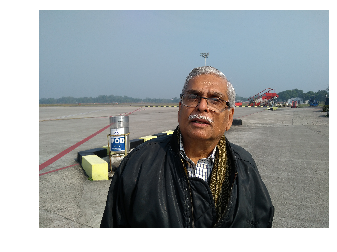

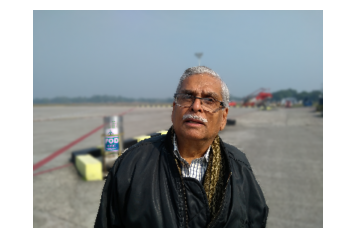

In [0]:
#!wget -nv https://drive.google.com/file/d/1Qn9D2x35UegcT2uWxJC94M5w3uxI8MHz/view?usp=sharing -O human.png
segment(dlab, './IMG_20171224_100341.jpg')